In [58]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
pd.set_option('display.max_colwidth', -1)

<ipython-input-58-1548e7712397>:6: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [59]:
import pandas as pd
import numpy as np
import re
import nltk
import contractions




from nltk.stem import PorterStemmer,WordNetLemmatizer
from nltk.corpus import stopwords,wordnet
from nltk.tokenize.treebank import TreebankWordDetokenizer,TreebankWordTokenizer
from nltk.tokenize import wordpunct_tokenize,TweetTokenizer



stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))



from autocorrect import Speller
spell = Speller(lang='en')
def autospell(text):
    spells = [spell(w) for w in (nltk.word_tokenize(text))]
    return " ".join(spells)


def pos_tagger(tag):
    nltk_tag=tag[1]
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV   
    return 'n'


stop_list=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves',\
     'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', \
     'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had',\
    'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'if', 'or', 'because', 'as', 'until','of', 'at', 'by', 'for', 'with', 'about', 'between',\
    'into', 'through', 'during', 'to', 'from','in', 'out','on','again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 
    'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 
    'just','should', 'now', 'd', 'll', 'm', 'o', 're', 've', 'y','u','im','go','will','come','whats','twitter','tweet',\
    'know','x','yeah','year','yet','youre','would','do','can','nan','see','look','one','could']

stop_reg = r'\b(?:'+'|'.join(stop_list)+r')\b'
stop_reg
stopword_finder= re.compile(stop_reg)


def processing(sentence, verbose=False):
  og_sentence = sentence
  sentence=sentence.lower()#CASE FOLDING
  html_finder = re.compile(r'<.*?>|&\w+;')
  rmhtml_Text=html_finder.sub('',sentence)  #remove HTML Tags
  # rmurl_Text = re.sub(r'http\S+|https:\S+|www\S+|.com\S+', '', rmhtml_Text) #remove URL tags
  pre_url = r'(?:https?://)|(?:www\.)'
  url_set = r'[\w+=?/._\-:;&*^$#@~`!|]'
  rmurl_Text=re.sub(f'(?:{pre_url}){url_set}+|{url_set}+\.com{url_set}*', '',rmhtml_Text)
  username_finder = re.compile('@\w+')
  rmurl_Text=username_finder.sub('',rmurl_Text) #remove usernames
  rmwhite_Text=re.sub(' +', ' ',rmurl_Text) #remove extra whitespace
  rmwhite_Text = contractions.fix(rmwhite_Text) #Remove contractions
  rmpunt_text=re.sub('[^\w\s]','',rmwhite_Text) #punctuation and username removal
  
  token_text=[token for token in TweetTokenizer().tokenize(rmpunt_text)]#tokenize text 
  
  # stem_text= [stemmer.stem(word) for word in rmpunt_text]#stemming
  pos_tags=[pos_tagger(tag) for tag in nltk.pos_tag(token_text)]
  lem_text= [lemmatizer.lemmatize(word,pos=pos) for word,pos in zip(token_text,pos_tags)] #lemmatize word
  # print(lem_text)
  rmstop_text = [tok for tok in lem_text if not stopword_finder.search(tok)]
  # print(rmstop_text)
  sentence=TreebankWordDetokenizer().detokenize(rmstop_text) #convert to sentence 
#   spell_sentence = autospell(sentence)
  if verbose:
    print(f'Original sentence :\n{og_sentence}\n')
    print(f'Removing HTML and (Lowercasing):\n{rmhtml_Text}\n')
    print(f'Removing URL tags (and usernames):\n{rmurl_Text}\n')
    print(f'Removing whitespace(and expand contractions):\n{rmwhite_Text}\n')
    print(f'Remove punctuations:\n{rmpunt_text}\n')   
    print(f'Tokenize Text:\n{token_text}\n')
    print(f'Lemmatize Text:\n{lem_text}\n')
    print(f'Removing stop words Text:\n{rmstop_text}\n')
    
  
  return sentence

In [60]:
df = pd.read_csv('../data/H2_Hate_Offensive_Language_Identification_train.csv')

In [61]:
data=df.apply(lambda row: processing(row.text,verbose=False),axis=1)

In [62]:
df['new_text'] = data

In [72]:
vectorizer = TfidfVectorizer()
X,y = df['new_text'],df['label']
X = vectorizer.fit_transform(X).toarray()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [64]:
#gradient boosting
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(n_estimators=100, random_state=0,verbose=1,learning_rate=0.5)
clf.fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1           1.2897            3.47m
         2           1.2322            3.31m
         3           1.1855            3.16m
         4           1.1589            3.08m
         5           1.1364            3.01m
         6           1.1115            2.96m
         7           1.0929            2.97m
         8           1.0763            2.97m
         9           1.0641            2.92m
        10           1.0514            2.87m
        20           0.9553            2.60m
        30           0.8952            2.28m
        40           0.8471            1.94m
        50           0.8040            1.62m
        60           0.7730            1.29m
        70           0.7445           57.34s
        80           0.7221           38.09s
        90           0.6957           19.01s
       100           0.6751            0.00s


GradientBoostingClassifier(learning_rate=0.5, random_state=0, verbose=1)

In [73]:
#f1 score
from sklearn.metrics import f1_score
y_pred = clf.predict(X_test)
f1_score(y_test, y_pred, average='macro')


0.7650719996665718

In [74]:
len(y_test)

760

In [79]:
y_test

ValueError: invalid literal for int() with base 10: 'HOF'

Text(33.0, 0.5, 'Actual')

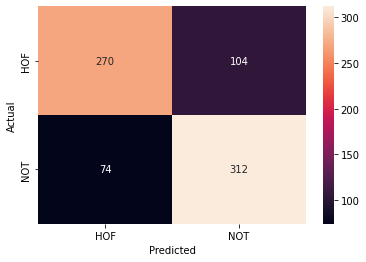

In [82]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
cm = confusion_matrix((y_test=='NOT').astype(int), (y_pred=='NOT').astype(int))

sns.heatmap(cm, annot=True, fmt='d',xticklabels=['HOF','NOT'],yticklabels=['HOF','NOT'])
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [68]:
df_test = pd.read_csv('../data/H2_Hate_Offensive_Language_Identification_test.csv')
data_test=df_test.apply(lambda row: processing(row.text,verbose=False),axis=1)
df_test['new_text'] = data_test
X_test = vectorizer.transform(df_test['new_text']).toarray()
y_pred = clf.predict(X_test)

In [69]:
mapping = {'NOT':1,'HOF':0}
predictions = pd.DataFrame(pd.Series(y_pred).replace(mapping), columns=['label'])
predictions['id'] = df_test['id']
predictions.to_csv('submission.csv',index=False)

In [76]:
X_train.shape

(6833, 16797)